In [1]:
from generate_paths import get_all_files
import six.moves.cPickle as pickle
import numpy as np
import copy
from joblib import Parallel, delayed

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import prettyplotlib as ppl
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [14]:
features = []
with open('features_inc.pkl', 'rb') as pickle_file:
    try:
       for _ in range(500000):
            entry = pickle.load(pickle_file, encoding='bytes', fix_imports=True)
            features.append(entry)
    except EOFError:
        pass

In [15]:
feat_list = ['key','mode','loudness','danceability','duration','energy','mode', 'end_of_fade_in', 'start_of_fade_out']

In [16]:
data = map(lambda x: x[1], features)
data = list(filter(lambda x: 'year' in x and x['year']>=1965, data))

In [17]:
len(data)

253956

In [20]:
granularity = 5
labels = list(map(lambda x: x['year'], data))
labels -= min(labels)
labels = np.array(list(map(int, labels)))
classes = list(map(lambda x: x//granularity, labels))

In [19]:
classes_to_data = {}
for i,entry in enumerate(data):
    cls = classes[i]
    classes_to_data.setdefault(cls, []).append(entry)
for cls in classes_to_data:
    classes_to_data[cls] = np.random.permutation(classes_to_data[cls])
min_len = min([len(x) for x in classes_to_data.values()])
uniform_data = np.random.permutation(np.array([subdata[:min_len] for subdata in classes_to_data.values()]).flatten())
data = uniform_data
len(data)

41900

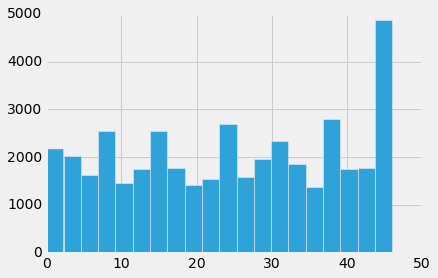

In [14]:
plt.hist(labels, 20);

In [19]:
BASELINE = 24
np.mean((labels-BASELINE)**2)

198.34906921241051

In [21]:
X = np.array([[entry[feat] for feat in feat_list] for entry in data])

In [29]:
regressors = [#LinearRegression(),
              Ridge(alpha = 0.1),
             ]
classifiers = [AdaBoostClassifier(),
               RidgeClassifier(alpha=1.0),
               #Perceptron(n_iter=50),
               #PassiveAggressiveClassifier(n_iter=50),
               #KNeighborsClassifier(n_neighbors=10),
               #RandomForestClassifier(),
               #RandomForestClassifier(n_estimators=200, criterion = 'entropy'),
               LinearSVC(dual=False),
               #MultinomialNB(alpha=0.1),
               #BernoulliNB(alpha=0.1),
               #SGDClassifier(alpha=.0001, n_iter=200, penalty='l2'),
               SVC()
              ]

In [30]:
for clf in regressors:
    scores = -cross_val_score(clf, X, labels, cv=5, scoring='neg_mean_squared_error')
    print(clf.__class__.__name__, 'Mean Square Deviations', scores)

Ridge Mean Square Deviations [ 183.4553739   182.79003997  180.57915907  176.56479655  181.4984808 ]


In [147]:
predictions = Parallel(n_jobs=-1)(
    delayed(cross_val_predict)(clf, X, classes, cv=5)
    for clf in classifiers)

In [148]:
tmp = list(zip(map(lambda x: x.__class__.__name__,classifiers), [metrics.accuracy_score(classes, predicted) for predicted in predictions]))
print(*tmp, sep='\n')

('AdaBoostClassifier', 0.17798485730926034)
('RidgeClassifier', 0.16048340128130459)
('LinearSVC', 0.16193942923704135)
('SVC', 0.16153174140943505)


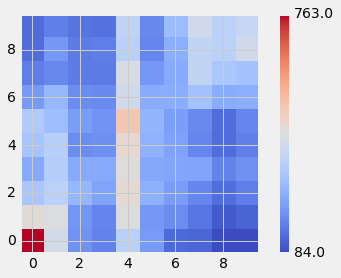

In [23]:
clf = classifiers[3]
train_rng = int(0.4*len(X))
clf.fit(X[:train_rng], classes[:train_rng])
predicted = clf.predict(X[train_rng:])
num_classes = len(set(classes))
heatmap = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
for x,y in zip(classes[train_rng:], predicted):
    heatmap[x][y] += 1.0

fig, ax = plt.subplots()

cax = ax.imshow(heatmap, origin='lower', interpolation='nearest', cmap=cm.coolwarm)

cbar = fig.colorbar(cax, ticks=[np.min(heatmap), np.max(heatmap)])
cbar.ax.set_yticklabels(map(lambda x: str(x), [np.min(heatmap), np.max(heatmap)]))

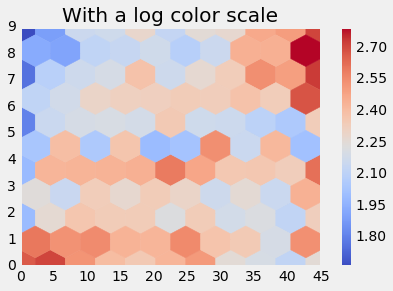

In [35]:
X = labels[train_rng:]
Y = predicted

xmin = min(X)
ymin = min(Y)
xmax = max(X)
ymax = max(Y)

plt.hexbin(X, Y, bins='log', gridsize=10, cmap=cm.coolwarm)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("With a log color scale")
cb = plt.colorbar()
#plt.ylim(ymax=2)

plt.show()

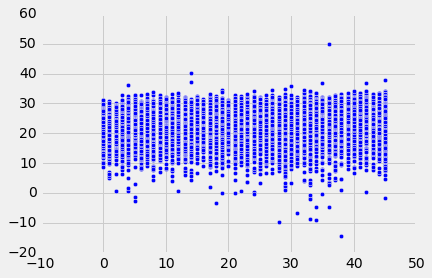

In [146]:
clf = Ridge(alpha = 1.0)
clf.fit(X, labels)
plt.scatter(labels, clf.predict(X))